# NFL Competition

# Feature Engineering e Modelo de Machine Learning

- Version: 1.0: usando padrao do fork: https://www.kaggle.com/bestpredict/location-eda-8eb410
        *    Resultado: 0.012744
        *    LB: 0.01363
   
- Version: 2.0: adicionado Feature Selection com LOFO Importance
        *    Resultado: 0.012780
        *    LB: 0.01365

- Version: 3.0: adicionado novas features (apenas feature fxx + old_data + YardLine_std)
        *    Resultado: 0.012614
        *    LB: 0.01361
        
- Version: 4.0: adicionado novas features (turf)
        *    Resultado: 0.012624
        *    LB: 0.01361
        
- Version: 5.0: adicionado novas features (game_time)
        *    Resultado: 0.012635
        *    LB: 0.01362
        
- Version: 6.0: adicionado novas features (feat1, feat2, feat3, feat4) e removido (Turf + game_time)
        *    Resultado: 0.012536
        *    LB: Não é permitido
        
- Version: 7.0: alteração do modelo de bagging
        *    Resultado: 0.012474
        *    LB: 0.01362

- Version: 8.0: adicionado novas features (accY, est_prev_yards)
        *    Resultado: 0.012616
        *    LB: 0.01362
        
- Version: 9.0: adicionado novas features (norm_quat,mod_quat,norm_X,norm_Y,norm_A,norm_S)
    
        *    Resultado: 0.012604
        *    LB: 0.01361

- Version: 12.0: realizando stacking dos modelos NN e RF
    
        *    Resultado: 0.012616
        *    LB: 0.01361
        
- Version: 13.0: inclusao de otimização no modelo de NN
    
        *    Resultado: 0.012587
        *    LB: 0.01361
        
- Version: 14.0: usando todos os dados do dataset para treino
    
        *    Resultado: 0.009x
        *    LB: 0.01379
        
- Version: 15.0: adicionando novas features (seconds_need_to_first_down, seconds_need_to_YardsLine, DefendersInTheBox_vs_Distance) e alguns ajustes no modelo
    
        *    Resultado: 0.012646
        *    LB: 0.01361
        
- Version: 16.0: fazendo blending de NN com LGB
    
        *    Resultado:
        *    LB:         

## 1. Importa os pacotes e o dataset de treino

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
import re
import codecs
import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb

# Importa os pacotes de algoritmos de redes neurais (Keras)
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
import keras.backend as K
from keras.optimizers import Adam
from keras import optimizers

# Importa pacotes do sklearn
from sklearn import preprocessing
import sklearn.metrics as mtr
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn import model_selection

Using TensorFlow backend.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
if TRAIN_OFFLINE:
    train  = pd.read_csv('../data/train.csv', dtype={'WindSpeed': 'object'})
else:
    train  = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})

In [5]:
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

## 2. Feature Engineering

In [38]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def strtofloat(x):
    try:
        return float(x)
    except:
        return -1
    
def get_time(x):
    x = x.split(":")
    return int(x[0])*60 + int(x[1])

def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

def OffensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def DefensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def orientation_to_cat(x):
    x = np.clip(x, 0, 360 - 1)
    try:
        return str(int(x/15))
    except:
        return "nan"    
    
def uid_aggregation(comb, main_columns, uids, aggregations):
    X = pd.DataFrame()
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = comb[[col, main_column]]
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                X[new_col_name] = comb[col].map(temp_df)
                del temp_df
                gc.collect()
    return X

def transform_time_quarter(str1):
    return int(str1[:2])*60 + int(str1[3:5])

def transform_time_all(str1,quarter):
    if quarter<=4:
        return 15*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60
    if quarter ==5:
        return 10*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60
    
def new_X(x_coordinate, play_direction):
    if play_direction == 'left':
        return 120.0 - x_coordinate
    else:
        return x_coordinate

def new_line(rush_team, field_position, yardline):
    if rush_team == field_position:
        # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
        return 10.0 + yardline
    else:
        # half the field plus the yards between midfield and the line of scrimmage
        return 60.0 + (50 - yardline)

def new_orientation(angle, play_direction):
    if play_direction == 'left':
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle

def euclidean_distance(x1,y1,x2,y2):
    x_diff = (x1-x2)**2
    y_diff = (y1-y2)**2
    return np.sqrt(x_diff + y_diff)

def back_direction(orientation):
    if orientation > 180.0:
        return 1
    else:
        return 0

def velocity(x2, x1, sec) :
    return (x2 - x1) / sec

def diff_x(b, c, theta) :
    if 90.0 < theta < 270.0 :
        return np.sqrt(((b ** 2) + (c ** 2)) - 2 * b * c * np.cos(theta))
    else :
        return 0

def diff_y(b, c, theta) :
    if theta <= 90.0 and theta >= 270.0 :
        return - np.sqrt(((b ** 2) + (c ** 2)) - 2 * b * c * np.cos(theta))
    else :
        return 0

def stop_period(speed, acc) :
    return speed / acc   

def new_roll_velocity(x1, y1, x2, y2) :  
    x_diff = np.sqrt((x1 - x2) ** 2)
    y_diff = np.sqrt((y1 - y2) ** 2)
    return np.sqrt(x_diff + y_diff) 

In [39]:
def add_centroid(tmp):
    '''
    Calculates centroid coordinates of offense and defense teams
    Takes into account rusher coordinates
    '''
    
    df = pd.DataFrame()
    
    for col in tmp.columns:
        if col in ['X','Y']:
            df[col+'_mean']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].mean()
            df[col+'_std']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].std()
    temp1= df.unstack()
    temp1.columns = ['Xc_def_mean','Xc_off_mean', 'Xc_def_std','Xc_off_std',
                    'Yc_def_mean','Yc_off_mean','Yc_def_std','Yc_off_std']
    #col = ['Xc_def_std','Yc_def_std','Xc_off_std','Yc_off_std']
    #temp1.drop(col, axis=1,inplace=True)
    
    temp2 = tmp.loc[tmp['IsRusher'] == True, ['GameId','PlayId','X','Y','Sx','Sy','Ax','Ay','F','Fx','Fy','p','px','py','pf_max','px_max','py_max']]
    temp2.columns = ['GameId','PlayId','X_rusher','Y_rusher','Sx_rusher','Sy_rusher','Ax_rusher','Ay_rusher','F_rusher','Fx_rusher','Fy_rusher','p_rusher','px_rusher','py_rusher','p_max_rusher','px_max_rusher','py_max_rusher']
    temp1 = temp1.merge(temp2, on=['GameId','PlayId'], how='left')
    new_tmp = tmp.merge(temp1, on=['GameId','PlayId'])

    return new_tmp

def add_x_y_components(df):
    '''
    Splits S and A into their x and y components
    Calculates max speed at given acceleration
    Calculates F and p, absolute and relatives
    '''
    df['S_'] = df['S'].apply(convert_yard_to_m)
    df['A_'] = df['A'].apply(convert_yard_to_m)
    
    df['Sx'] = df['S']*np.cos(df['Dir'])
    
    df['Sy'] = df['S']*np.sin(df['Dir'])
    df['Sy_'] = np.abs(df['S']*np.sin(df['Dir'])) 
    
    df['Ax'] = df['A']*np.cos(df['Dir'])
    df['Ay'] = df['A']*np.sin(df['Dir'])
    
    df['Sfx'] = df['Sx']+df['Ax']*3.5
    df['Sfy'] = df['Sy']+df['Ay']*3.5
    
    df['F'] = df['PlayerWeight_kg']*df['A_']
    df['Fx'] = df['F']*np.cos(df['Dir'])
    df['Fy'] = df['F']*np.sin(df['Dir'])

    df['p'] = df['PlayerWeight_kg']*df['S_']
    df['px'] = df['p']*np.cos(df['Dir'])
    df['py'] = df['p']*np.sin(df['Dir'])
    
    df['pf_max'] = df['PlayerWeight_kg']*(np.sqrt(df['Sfx']**2+df['Sfy']**2))
    #df['pf_max'] = df['PlayerWeight']*9
    
    df['px_max'] = df['pf_max']*np.cos(df['Dir'])
    df['py_max'] = df['pf_max']*np.sin(df['Dir'])
    
    df['KE'] = (1/2) * df['PlayerWeight_kg'] * (df['S_'] ** 2)

    
    del df['A_']
    del df['S_']
    
    return df
    
def l2_norm_mat(mat_v, mat_u):
    '''
    Calculates euclidean distance
    '''
    return np.linalg.norm(mat_v - mat_u, axis=1)    

def calculate_distance(tmp): 
    '''
    Calculates euclidean distance for below components
    '''

    mat_u = np.array(tmp[['X','Y']])
    mat_v = np.array(tmp[['Xc_def_mean','Yc_def_mean']])
    mat_w = np.array(tmp[['Xc_off_mean','Yc_off_mean']])
    mat_z = np.array(tmp[['X_rusher','Y_rusher']])
    
    tmp['dist_cdef_vs_coff'] = l2_norm_mat(mat_v, mat_w)
    tmp['dist_cdef_vs_player'] = l2_norm_mat(mat_u, mat_v)
    tmp['dist_coff_vs_player'] = l2_norm_mat(mat_u, mat_w)
    tmp['dist_cdef_vs_rusher'] = l2_norm_mat(mat_z, mat_v)
    tmp['dist_coff_vs_rusher'] = l2_norm_mat(mat_z, mat_w)
    tmp['dist_player_vs_rusher'] = l2_norm_mat(mat_u, mat_z)
    
    return tmp

def add_rushertimeto1stdown(data):
    '''
    Calculates time needed for 1st down (based on Distance)
    '''
    tmp = data.copy()
    tmp = tmp.loc[tmp['IsRusher']==True,['GameId','PlayId','X','Sx_rusher','Ax_rusher','Dis','Distance','YardLine']]
    # below corrected
    tmp['S0x_rusher'] = np.sqrt(np.square(tmp['Sx_rusher'])-2*(tmp['Ax_rusher'])*(tmp['Dis']))
    tmp['S0x_rusher'].fillna(np.sqrt(-np.square(tmp['Sx_rusher'])-2*(-tmp['Ax_rusher'])*(tmp['Dis'])), inplace = True)
    tmp['rusher_dist_to_yardline'] = tmp['YardLine']-tmp['X']
    tmp['rusher_dist_to_1stdown'] = tmp['rusher_dist_to_yardline'] + tmp['Distance']
    # tmp['Disc_1'] = (tmp['Sx_rusher'])**2-(4*(tmp['Ax_rusher']/2)*(-tmp['Distance']))
    tmp['Disc_1'] = (tmp['S0x_rusher'])**2-(4*(tmp['Ax_rusher']/2)*(-tmp['rusher_dist_to_1stdown']))
    tmp['t_1stDown'] = (-tmp['S0x_rusher'] + np.sqrt(tmp['Disc_1'])/(tmp['Ax_rusher']))
    S_max_rusher = tmp.loc[tmp['Sx_rusher']>0,'Sx_rusher'].median()
    tmp['t_1stDown'].fillna(2*tmp['rusher_dist_to_1stdown']/S_max_rusher, inplace=True)
    tmp.loc[np.isneginf(tmp['t_1stDown'])==True,['t_1stDown']] = -1.0
    tmp.loc[np.isposinf(tmp['t_1stDown'])==True,['t_1stDown']] = -1.0


    col = ['Sx_rusher','Ax_rusher','Dis','Distance','Disc_1','X','YardLine','rusher_dist_to_yardline']
    tmp.drop(col,axis= 1, inplace= True)
    
    data = data.merge(tmp, on=['GameId','PlayId'], how='left')
    
    return data

def calc_timetotackle(tmp): # it doesnt get affected 
    '''
    Calculates time needed to tackle rusher
    '''
    df = pd.DataFrame()
    tmp = tmp.loc[tmp['IsOnOffense']==False,['GameId','PlayId','Sx','Sx_rusher','X','X_rusher','Ax','Ax_rusher','Sy','Sy_rusher','Y','Y_rusher','Ay','Ay_rusher','IsOnOffense']]
    tmp['Dx'] = np.square(tmp['Sx']-tmp['Sx_rusher'])-4*(tmp['X']-tmp['X_rusher'])*(tmp['Ax']-tmp['Ax_rusher'])/2 
    tmp['Dy'] = np.square(tmp['Sy']-tmp['Sy_rusher'])-4*(tmp['Y']-tmp['Y_rusher'])*(tmp['Ay']-tmp['Ay_rusher'])/2 


    #tmp['t1'] = (-(tmp['Sx']-tmp['Sx_rusher'])+np.sqrt(tmp['D']))/(2*(tmp['Ax']-tmp['Ax_rusher'])/2)
    tmp['tx'] = (-(tmp['Sx']-tmp['Sx_rusher'])-np.sqrt(tmp['Dx']))/(2*(tmp['Ax']-tmp['Ax_rusher'])/2)
    tmp['ty'] = (-(tmp['Sy']-tmp['Sy_rusher'])-np.sqrt(tmp['Dy']))/(2*(tmp['Ay']-tmp['Ay_rusher'])/2)
    
    tmp['tx'].fillna((-(tmp['Sx']-tmp['Sx_rusher']))/(2*(tmp['Ax']-tmp['Ax_rusher'])/2), inplace = True)
    tmp['ty'].fillna((-(tmp['Sy']-tmp['Sy_rusher']))/(2*(tmp['Ay']-tmp['Ay_rusher'])/2), inplace = True)
    
    tmp['time_to_tackle'] = np.sqrt(np.square(tmp['tx']) + np.square(tmp['ty']))
    
    for col in tmp.columns:
        if col in ['time_to_tackle']:
            df[col+'_mean']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].mean()
            df[col+'_min']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].min()
            df[col+'_max']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].max()
            
    tmp2 = df.unstack()
    tmp2.columns = ['time_to_tackle_mean','time_to_tackle_min','time_to_tackle_max']#,'time_to_tackle_cnt']
    
    tmp2.loc[np.isposinf(tmp2['time_to_tackle_max'])==True,['time_to_tackle_mean','time_to_tackle_max']] = tmp2['time_to_tackle_min']
    tmp2.loc[np.isposinf(tmp2['time_to_tackle_min'])==True,['time_to_tackle_min']] = 40
    tmp2.loc[np.isposinf(tmp2['time_to_tackle_max'])==True,['time_to_tackle_max']] = 40
    tmp2.loc[np.isposinf(tmp2['time_to_tackle_mean'])==True,['time_to_tackle_mean']] = 40
    
    return tmp2

def add_distance_ratios(data, deploy=False):
    
    tmp = data.copy()
    
    tmp1 = tmp.loc[:,['GameId','PlayId','IsOnOffense','IsRusher','dist_player_vs_rusher']]
    tmp1['dist_from_rusher_cat'] = tmp1['dist_player_vs_rusher'].apply(lambda x: map_distance_from_rusher(x))

    enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
    
    if not deploy:
        new_column = pd.DataFrame(enc.fit_transform(np.array(tmp1['dist_from_rusher_cat']).reshape(-1,1)))
    else:
        new_column = pd.DataFrame(enc.transform(np.array(tmp1['dist_from_rusher_cat']).reshape(-1,1)))  
    
    new_column.columns = ['D1','D2','D3','D4','D5','D6','D7']

    tmp = pd.merge(tmp, new_column, left_index=True, right_index=True,how ='left')

    tmp2 = tmp.loc[(tmp1['IsRusher']!=1)&(tmp['IsOnOffense']==1),['GameId','PlayId','NflId','IsOnOffense','dist_player_vs_rusher','dist_from_rusher_cat','D1','D2','D3','D4','D5','D6','D7']]

    df = pd.DataFrame()
    for col in ['D1','D2','D3','D4','D5','D6','D7']:
        df[col+'_cnt_off'] = tmp2.groupby(['GameId','PlayId'])[col].sum()

    tmp2 = tmp.loc[(tmp1['IsOnOffense']==0),['GameId','PlayId','NflId','IsOnOffense','dist_player_vs_rusher','dist_from_rusher_cat','D1','D2','D3','D4','D5','D6','D7']]

    for col in ['D1','D2','D3','D4','D5','D6','D7']:
        df[col+'_cnt_def'] = tmp2.groupby(['GameId','PlayId'])[col].sum()


    weights = [2, 0.9,0.8,0.7,0.6,0.5,0.4]
    df['dist_from_rusher_DEF'] = np.dot(df[['D1_cnt_def','D2_cnt_def','D3_cnt_def','D4_cnt_def','D5_cnt_def','D6_cnt_def','D7_cnt_def']],weights)/np.sum(weights)
    df['dist_from_rusher_OFF'] = np.dot(df[['D1_cnt_off','D2_cnt_off','D3_cnt_off','D4_cnt_off','D5_cnt_off','D6_cnt_off','D7_cnt_off']],weights)/np.sum(weights)
    df['dist_from_rusher_ratio'] = df['dist_from_rusher_OFF']/df['dist_from_rusher_DEF']

    
    cols = ['D1_cnt_def','D2_cnt_def','D3_cnt_def','D4_cnt_def','D5_cnt_def','D6_cnt_def','D7_cnt_def','D1_cnt_off','D2_cnt_off','D3_cnt_off','D4_cnt_off','D5_cnt_off','D6_cnt_off','D7_cnt_off']
    df.drop(cols, axis = 1, inplace = True)


    data = pd.merge(data, df, on=['GameId','PlayId'], how='left')
    
    return data

# Funcao para converter peso em lbs para kg
def convert_to_kg(lbs):
    kg = lbs * 0.45359237
    #print("The weight is", kg, "in kilograms")
    
    return kg

# Funcao para converter yard to m
def convert_yard_to_m(yard):
    m = yard * 0.9144    
    return m

def map_distance_from_rusher(distance):
    if np.square(distance)<= np.square(1):
        return '1'
    elif np.square(distance)<= np.square(2):
        return '2'
    elif np.square(distance)<= np.square(3):
        return '3'
    elif np.square(distance)<= np.square(4):
        return '4'
    elif np.square(distance)<= np.square(5):
        return '5'
    elif np.square(distance)<= np.square(10):
        return '6'
    else:
        return '7'

def s_ratio_runner_vs_1stdef(data):
    tmp = data.loc[((data['dist_player_vs_rusher'])==(data['dist_player_vs_rusher_min_NOnOff']))&(data['IsOnOffense']==False),['GameId','PlayId','Sx','Sx_rusher']]
    tmp['rusher_1stdef_sx_ratio'] = tmp['Sx_rusher']/tmp['Sx']
    drop = ['Sx','Sx_rusher']
    tmp.drop(drop, axis = 1, inplace = True)
    
    return tmp

def add_players_data(tmp):
    '''
    Calculates mean and minimum distances
    '''
    
    df = pd.DataFrame()
    
    for col in tmp.columns:
        if col in ['dist_cdef_vs_player','dist_coff_vs_player','dist_player_vs_rusher']:
            df[col+'_mean']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].mean()
            df[col+'_min']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].min()
            
    temp1= df.unstack()
    temp1.columns = ['dist_cdef_vs_player_mean_NOnOff','dist_cdef_vs_player_mean_OnOff','dist_cdef_vs_player_min_NOnOff','dist_cdef_vs_player_min_OnOff',
    'dist_coff_vs_player_mean_NOnOff','dist_coff_vs_player_mean_OnOff','dist_coff_vs_player_min_NOnOff','dist_coff_vs_player_min_OnOff',
    'dist_player_vs_rusher_mean_NOnOff','dist_player_vs_rusher_mean_OnOff','dist_player_vs_rusher_min_NOnOff','dist_player_vs_rusher_min_OnOff']
    #tmp = tmp.merge(temp1, on=['GameId','PlayId'], how='left')

    return temp1

def clf_yards(x):

    y = 2
    if x<= -7:
        y=0
    elif x<=-2:
        y=1
    elif x<=0:
        y=2
    elif x<=2:
        y=3
    elif x<=5:
        y=4
    elif x<=10:
        y=5
    elif x<=20:
        y=6
    elif x<=40:
        y=7
    else:
        y=8
    return y

def fill_defendersinabox(x, y): # x=DefensePersonnel y=Defenderinthebox
    
    if x =='4 DL, 2 LB, 5 DB':
        y = 6
    elif x =='4 DL, 3 LB, 4 DB':
        y = 7
    elif x == '3 DL, 4 LB, 4 DB':
        y = 7
    elif x == '2 DL, 4 LB, 5 DB':
        y = 6
    elif x == '3 DL, 3 LB, 5 DB':
        y = 6

    return y


def map_DefensePersonnel(x):

    if x =='4 DL, 2 LB, 5 DB':
        y = 0
    elif x =='4 DL, 3 LB, 4 DB':
        y = 1
    elif x == '3 DL, 4 LB, 4 DB':
        y = 2
    elif x == '2 DL, 4 LB, 5 DB':
        y = 3
    elif x == '3 DL, 3 LB, 5 DB':
        y = 4
    else:
        y = 5
    return y

map_offense_formation = {'SINGLEBACK':0,
                         'SHOTGUN':1,
                         'I_FORM':2,
                         'PISTOL':3,
                         'JUMBO':4,
                         'WILDCAT':5,
                         'ACE':6,
                         'EMPTY':7,
                        }

In [40]:
def create_features_01(df, deploy=False):

    
    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]
        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')
        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X','Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]
        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense
            
    def rusher_features(df):
        
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Dir', 'S', 'A', 'X', 'Y']]
        rusher.columns = ['GameId','PlayId', 'RusherDir', 'RusherS', 'RusherA', 'RusherX', 'RusherY']
       
        radian_angle = (90 - rusher['RusherDir']) * np.pi / 180.0
        v_horizontal = np.abs(rusher['RusherS'] * np.cos(radian_angle))
        v_vertical = np.abs(rusher['RusherS'] * np.sin(radian_angle)) 
       
        rusher['v_horizontal'] = v_horizontal
        rusher['v_vertical'] = v_vertical
        
        rusher.columns = ['GameId','PlayId', 'RusherDir', 'RusherS','RusherA','RusherX', 'RusherY','v_horizontal', 'v_vertical']
        
        return rusher
    
    def static_features(df):
        
        
        add_new_feas = []

        ## Height
        df['PlayerHeight_dense'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
        
        
        add_new_feas.append('PlayerHeight_dense')

        ## Time
        df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
        df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

        df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
        df['PlayerBirthDate'] =df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

        ## Age
        seconds_in_year = 60*60*24*365.25
        df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
        add_new_feas.append('PlayerAge')

        ## WindSpeed
        df['WindSpeed_ob'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
        df['WindSpeed_dense'] = df['WindSpeed_ob'].apply(strtofloat)
        add_new_feas.append('WindSpeed_dense')

        ## Weather
        df['GameWeather_process'] = df['GameWeather'].str.lower()
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
        df['GameWeather_dense'] = df['GameWeather_process'].apply(map_weather)
        add_new_feas.append('GameWeather_dense')

        ## Orientation and Dir
        df["Orientation_ob"] = df["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
        df["Dir_ob"] = df["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

        df["Orientation_sin"] = df["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Orientation_cos"] = df["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        
        df["Dir_sin"] = df["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Dir_cos"] = df["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        
        add_new_feas.append("Dir_sin")
        add_new_feas.append("Dir_cos")

        ## diff Score
        df["diffScoreBeforePlay"] = df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"]
        add_new_feas.append("diffScoreBeforePlay")
    
        static_features = df[df['NflId'] == df['NflIdRusher']][add_new_feas+['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                                             'YardLine','Quarter','Down','Distance',
                                                                             'NflId','NflIdRusher','PossessionTeam','HomeTeamAbbr','Turf',
                                                                             'VisitorTeamAbbr','PlayDirection','GameClock','Season','Team',
                                                                             'FieldPosition','DefendersInTheBox']].drop_duplicates()
        #static_features.fillna(-999,inplace=True)

        return static_features


    def combine_features(relative_to_back, defense, rushing, static, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,rushing,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')
        
        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df
    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)

    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    rush_feats = rusher_features(df)
    basetable = combine_features(rel_back, def_feats, rush_feats, static_feats,deploy = deploy)
    
    return basetable

In [41]:
def create_features_02(t_):
    
    t_['fe1'] = pd.Series(np.sqrt(np.absolute(np.square(t_.X.values) - np.square(t_.Y.values))))
    t_['fe5'] = np.square(t_['S'].values) + 2 * t_['A'].values * t_['Dis'].values  # N
    t_['fe7'] = np.arccos(np.clip(t_['X'].values / t_['Y'].values, -1, 1))  # N
    t_['fe8'] = t_['S'].values / np.clip(t_['fe1'].values, 0.6, None)
    radian_angle = (90 - t_['Dir']) * np.pi / 180.0
    t_['fe10'] = np.abs(t_['S'] * np.cos(radian_angle))
    t_['fe11'] = np.abs(t_['S'] * np.sin(radian_angle))

    t_['IsRusher'] = (t_['NflId'] == t_['NflIdRusher'])
    temp = t_[t_["IsRusher"]][["Team", "PlayId"]].rename(columns={"Team":"RusherTeam"})
    t_ = t_.merge(temp, on = "PlayId")
    t_["IsRusherTeam"] = t_["Team"] == t_["RusherTeam"]    

    t_["is_left"]            = t_["PlayDirection"] == "left"
    t_["old_data"]    = t_["Season"] == 2017
    t_['YardLine_std'] = 100 - t_['YardLine']
    
    t_['Orientation_rad'] = np.mod(t_.Orientation, 360) * np.pi/180.0
    t_.loc[t_.Season >= 2018, 'Orientation_rad'] = np.mod(t_.loc[t_.Season >= 2018, 'Orientation'] - 90, 360) * np.pi/180.0
    t_['Orientation_std'] = t_.Orientation_rad
    t_.loc[t_.is_left, 'Orientation_std'] = np.mod(np.pi + t_.loc[t_.is_left, 'Orientation_rad'], 2*np.pi)
    
    t_['norm_quat'] = (t_['X']**2 + t_['Y']**2 + t_['A']**2 + t_['S']**2)
    t_['mod_quat'] = (t_['norm_quat'])**0.5
    t_['norm_X'] = t_['X'] / t_['mod_quat']
    t_['norm_Y'] = t_['Y'] / t_['mod_quat']
    t_['norm_A'] = t_['A'] / t_['mod_quat']
    t_['norm_S'] = t_['S'] / t_['mod_quat']    

    t_['seconds_need_to_first_down'] = (t_['Distance']*0.9144)/t_['Dis']
    t_['seconds_need_to_YardsLine'] = (t_['YardLine']*0.9144)/t_['Dis']    
    t_['DefendersInTheBox_vs_Distance'] = t_['DefendersInTheBox'] / t_['Distance']    

    t_['time_quarter'] = t_.GameClock.map(lambda x:transform_time_quarter(x))
    t_['time_end'] = t_.apply(lambda x:transform_time_all(x.loc['GameClock'],x.loc['Quarter']),axis=1)

    Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
            'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
            'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
            'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
            'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

    t_['Turf'] = t_['Turf'].map(Turf)
    t_['Turf'] = t_['Turf'] == 'Natural'
    
    t_ = t_.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'IsRusherTeam', 'IsRusher']).reset_index(drop = True)

    return t_

In [42]:
def create_features_03(df, deploy=False):

    
    df['IsRusher'] = df.NflId == df.NflIdRusher
    df['TeamOnOffense'] = "home"
    
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    
    df['IsOnOffense'] = df.Team == df.TeamOnOffense # Is player on offense?
    df['PlayerWeight_kg'] = df['PlayerWeight'].apply(lambda x: convert_to_kg(x))
    df['OffenseFormation'] = df['OffenseFormation'].map(map_offense_formation)
    df['DefendersInTheBox'] = df[['DefensePersonnel','DefendersInTheBox']].apply(lambda x: fill_defendersinabox(x[0],x[1]), axis=1)
    df['DefensePersonnel'] = df['DefensePersonnel'].apply(map_DefensePersonnel)
    
    
    df = add_x_y_components(df)
    df = add_centroid(df)
    # Calculates time needed to make 1st down
    df = add_rushertimeto1stdown(df)
    
    # Calculate distances between offense, defense, rusher and players
    df = calculate_distance(df)

    df = add_distance_ratios(df, deploy=deploy)

    # Calculates time to tackle
    timetotackle = calc_timetotackle(df)
    df = pd.merge(df, timetotackle, on=['GameId','PlayId'], how= 'left')

    play_data = add_players_data(df)
    df = pd.merge(df, play_data, on=['GameId','PlayId'], how= 'left')
    # Calculates ratio between speeds from rusher and closest defenser
    to_merge_S = s_ratio_runner_vs_1stdef(df)
    df = pd.merge(df, to_merge_S, on=['GameId','PlayId'], how='left')
    
    df = df.loc[df['IsRusher']==1,:]
    cols = [ 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'NflId', 'DisplayName',
            'JerseyNumber', 'Season', 'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance', 
            'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher', 
            'OffensePersonnel', 
            'PlayDirection', 'TimeHandoff', 'TimeSnap', 'PlayerHeight', 'PlayerWeight', 
            'PlayerBirthDate', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 
            'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'Temperature',
            'Humidity', 'WindSpeed', 'WindDirection', 'YardLine', 'IsRusher', 'TeamOnOffense', 
            'IsOnOffense', 'PlayerWeight_kg',
            'X_rusher','Y_rusher','Sx_rusher','Sy_rusher','Ax_rusher','Ay_rusher','F_rusher','Fx_rusher',
            'Fy_rusher','p_rusher','px_rusher','py_rusher','p_max_rusher','px_max_rusher','py_max_rusher',
            'dist_player_vs_rusher']
    df.drop(cols, axis=1, inplace=True)
    feat = [col for col in df.columns if col not in ['Yards']]
    df = df[feat]
    
    return df

In [43]:
%time train_basetable_01 = create_features_01(train, False)

CPU times: user 3min 1s, sys: 6.86 s, total: 3min 8s
Wall time: 2min 53s


In [44]:
train_basetable_01.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,RusherDir,RusherS,RusherA,RusherX,RusherY,v_horizontal,v_vertical,PlayerHeight_dense,PlayerAge,WindSpeed_dense,GameWeather_dense,Dir_sin,Dir_cos,diffScoreBeforePlay,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,NflId,NflIdRusher,PossessionTeam,HomeTeamAbbr,Turf,VisitorTeamAbbr,PlayDirection,GameClock,Season,Team,FieldPosition,DefendersInTheBox,Yards
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,114.26,3.63,3.35,41.25,30.53,3.309436,1.491487,70,25.596251,8.0,1.0,0.911690,-0.410878,0,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,2543773,2543773,NE,NE,Field Turf,KC,left,14:14:00,2017,home,NE,6.0,8
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,47.80,3.06,2.41,48.93,27.16,2.266862,2.055465,70,25.596252,8.0,1.0,0.740805,0.671721,0,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,2543773,2543773,NE,NE,Field Turf,KC,left,13:52:00,2017,home,NE,6.0,3
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,138.04,5.77,2.42,71.34,19.11,3.857889,4.290640,70,25.596253,8.0,1.0,0.668612,-0.743612,0,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,2543773,2543773,NE,NE,Field Turf,KC,left,13:02:00,2017,home,KC,7.0,5
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,84.56,4.45,3.20,104.47,25.36,4.429957,0.421875,71,26.852933,8.0,1.0,0.995496,0.094803,0,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,2539663,2539663,NE,NE,Field Turf,KC,left,12:12:00,2017,home,KC,9.0,2
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,157.92,3.90,2.53,29.99,27.12,1.466013,3.613974,71,22.091819,8.0,1.0,0.375901,-0.926660,7,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,2557917,2557917,KC,NE,Field Turf,KC,right,12:08:00,2017,away,KC,7.0,7


In [45]:
%time train_basetable_02 = create_features_02(train_basetable_01)

CPU times: user 2.21 s, sys: 222 ms, total: 2.43 s
Wall time: 1.45 s


In [46]:
train_basetable_02.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,RusherDir,RusherS,RusherA,RusherX,RusherY,v_horizontal,v_vertical,PlayerHeight_dense,PlayerAge,WindSpeed_dense,GameWeather_dense,Dir_sin,Dir_cos,diffScoreBeforePlay,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,NflId,NflIdRusher,PossessionTeam,HomeTeamAbbr,Turf,VisitorTeamAbbr,PlayDirection,GameClock,Season,Team,FieldPosition,DefendersInTheBox,Yards,fe1,fe5,fe7,fe8,fe10,fe11,IsRusher,RusherTeam,IsRusherTeam,is_left,old_data,YardLine_std,Orientation_rad,Orientation_std,norm_quat,mod_quat,norm_X,norm_Y,norm_A,norm_S,seconds_need_to_first_down,seconds_need_to_YardsLine,DefendersInTheBox_vs_Distance,time_quarter,time_end
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,114.26,3.63,3.35,41.25,30.53,3.309436,1.491487,70,25.596251,8.0,1.0,0.911690,-0.410878,0,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,2543773,2543773,NE,NE,False,KC,left,14:14:00,2017,home,NE,6.0,8,27.739531,15.7229,0.0,0.130860,3.309436,1.491487,True,home,True,True,True,55.0,3.456101,0.314508,2658.0428,51.556210,0.800098,0.592169,0.064978,0.070409,4.812632,108.284211,3.0,854,46
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,47.80,3.06,2.41,48.93,27.16,2.266862,2.055465,70,25.596252,8.0,1.0,0.740805,0.671721,0,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,2543773,2543773,NE,NE,False,KC,left,13:52:00,2017,home,NE,6.0,3,40.699869,11.0024,0.0,0.075185,2.266862,2.055465,True,home,True,True,True,47.0,2.605777,5.747369,3146.9822,56.097970,0.872224,0.484153,0.042961,0.054547,26.894118,142.538824,0.6,832,68
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,138.04,5.77,2.42,71.34,19.11,3.857889,4.290640,70,25.596253,8.0,1.0,0.668612,-0.743612,0,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,2543773,2543773,NE,NE,False,KC,left,13:02:00,2017,home,KC,7.0,5,68.732841,36.1969,0.0,0.083948,3.857889,4.290640,True,home,True,True,True,25.0,3.825413,0.683820,5493.7370,74.119748,0.962497,0.257826,0.032650,0.077847,15.240000,114.300000,0.7,782,118
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,84.56,4.45,3.20,104.47,25.36,4.429957,0.421875,71,26.852933,8.0,1.0,0.995496,0.094803,0,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,2539663,2539663,NE,NE,False,KC,left,12:12:00,2017,home,KC,9.0,2,101.345209,22.7465,0.0,0.043909,4.429957,0.421875,True,home,True,True,True,-8.0,3.033033,6.174626,11587.1530,107.643639,0.970517,0.235592,0.029728,0.041340,3.975652,214.685217,4.5,732,168
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,157.92,3.90,2.53,29.99,27.12,1.466013,3.613974,71,22.091819,8.0,1.0,0.375901,-0.926660,7,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,2557917,2557917,KC,NE,False,KC,right,12:08:00,2017,away,KC,7.0,7,12.802566,17.4364,0.0,0.304626,1.466013,3.613974,True,away,True,False,True,65.0,0.598124,0.598124,1656.5054,40.700189,0.736852,0.666336,0.062162,0.095823,20.781818,72.736364,0.7,728,172


In [47]:
%time train_basetable_03 = create_features_03(train, False)

CPU times: user 1min 40s, sys: 12.2 s, total: 1min 52s
Wall time: 1min 35s


In [48]:
train_basetable_03.head()

,GameId,PlayId,OffenseFormation,DefendersInTheBox,DefensePersonnel,fe1,fe5,fe7,fe8,fe10,fe11,Sx,Sy,Sy_,Ax,Ay,Sfx,Sfy,F,Fx,Fy,p,px,py,pf_max,px_max,py_max,KE,Xc_def_mean,Xc_off_mean,Xc_def_std,Xc_off_std,Yc_def_mean,Yc_off_mean,Yc_def_std,Yc_off_std,S0x_rusher,rusher_dist_to_1stdown,t_1stDown,dist_cdef_vs_coff,dist_cdef_vs_player,dist_coff_vs_player,dist_cdef_vs_rusher,dist_coff_vs_rusher,dist_from_rusher_DEF,dist_from_rusher_OFF,dist_from_rusher_ratio,time_to_tackle_mean,time_to_tackle_min,time_to_tackle_max,dist_cdef_vs_player_mean_NOnOff,dist_cdef_vs_player_mean_OnOff,dist_cdef_vs_player_min_NOnOff,dist_cdef_vs_player_min_OnOff,dist_coff_vs_player_mean_NOnOff,dist_coff_vs_player_mean_OnOff,dist_coff_vs_player_min_NOnOff,dist_coff_vs_player_min_OnOff,dist_player_vs_rusher_mean_NOnOff,dist_player_vs_rusher_mean_OnOff,dist_player_vs_rusher_min_NOnOff,dist_player_vs_rusher_min_OnOff,rusher_1stdef_sx_ratio
18,2017090700,20170907000118,NaN,6.0,5,72.591195,15.7229,0.000000,0.050006,3.309436,1.491487,1.440730,3.331846,3.331846,1.329599,3.074844,6.094328,14.093800,284.839770,113.051571,261.444137,308.647273,122.500658,283.296184,1427.806722,566.689806,1310.532221,512.242125,48.179091,44.057273,5.294079,1.772665,28.890909,28.535455,7.014714,5.855606,1.032089,-4.25,-3.125090,4.137117,7.120317,3.443689,7.120317,3.443689,0.898305,0.983051,1.094340,3.344904,1.440090,9.635898,7.308391,6.541702,1.244395,2.768585,8.064384,4.978694,1.829416,1.364298,9.752491,5.609122,4.593310,0.0,-7.261317
40,2017090700,20170907000139,NaN,6.0,5,65.675561,11.0024,0.000000,0.046593,2.266862,2.055465,-2.386839,-1.914837,1.914837,-1.879831,-1.508090,-8.966246,-7.193153,204.914581,-159.835978,-128.228100,260.181999,-202.945266,-162.812442,1068.879080,-833.739270,-668.865695,364.002942,56.561818,51.867273,5.406292,2.001380,24.892727,24.762727,7.190716,6.932502,2.641076,4.07,2.992733,4.696345,7.961481,3.791370,7.961481,3.791370,0.864407,1.152542,1.333333,5.375678,2.039815,15.312521,7.351094,7.734453,2.300846,4.014345,8.317330,5.893499,1.609979,1.068196,10.297028,6.149070,4.287773,0.0,12.455140
62,2017090700,20170907000189,NaN,7.0,5,44.750458,36.1969,0.000000,0.128937,3.857889,4.290640,5.666081,-1.090151,1.090151,2.376415,-0.457221,13.983534,-2.690424,205.764849,202.058969,-38.876032,490.604618,481.768700,-92.692026,1324.126847,1300.278972,-250.172941,1294.236570,78.389091,74.848182,4.720893,2.115286,22.602727,21.450909,6.577620,6.044208,5.408583,-26.34,-19.368206,3.723536,7.866945,4.217487,7.866945,4.217487,0.898305,0.915254,1.018868,4.721756,0.526439,14.630287,6.501208,6.401627,0.676145,1.669572,7.094503,5.099697,1.137575,1.453946,9.903689,6.290334,4.221670,0.0,2.540479
84,2017090700,20170907000345,NaN,9.0,5,20.048658,22.7465,0.911727,0.221960,4.429957,0.421875,-4.296982,1.156912,1.156912,-3.089965,0.831936,-15.111858,4.068689,278.721988,-269.137843,72.462185,387.597765,-374.269813,100.767725,1490.731324,-1439.470978,387.560555,788.583156,109.310909,107.719091,0.962418,1.898686,25.733636,25.800000,4.505029,3.154869,4.615931,-100.47,-12.817239,1.593201,4.855307,3.278749,4.855307,3.278749,1.000000,1.203390,1.203390,3.876753,1.235714,10.511767,3.757735,3.324738,0.960504,0.650458,4.162894,3.099234,1.454885,1.017417,6.309354,4.284914,4.528002,0.0,-4.692999
98,2017090700,20170907000395,NaN,7.0,5,12.802566,17.4364,0.000000,0.304626,1.466013,3.613974,2.602038,2.905064,2.905064,1.687989,1.884567,8.509999,9.501050,226.660702,151.225586,168.836892,349.397921,233.114540,260.262403,1249.683267,833.775252,930.874372,623.004444,38.413636,33.135455,5.391251,2.056883,26.586364,27.061818,7.864325,7.423977,2.298950,5.01,0.492278,5.299553,8.440522,3.145993,8.440522,3.145993,0.864407,1.118644,1.294118,2.304873,0.967271,3.916981,8.064756,8.351504,1.904554,3.348826,8.884932,5.856800,1.242061,0.660645,11.056456,6.447653,4.288088,0.0,6.108834


In [52]:
X = pd.merge(train_basetable_02, train_basetable_03, on=['GameId','PlayId'], how='inner')
X.shape

(23171, 137)

In [53]:
# Cria uma copia do dataset para backup
#X = train_basetable.copy()
#X['count'] = X.groupby('Yards')['Yards'].transform('count')
#X = X[X['count'] >= 20]

In [54]:
X.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,RusherDir,RusherS,RusherA,RusherX,RusherY,v_horizontal,v_vertical,PlayerHeight_dense,PlayerAge,WindSpeed_dense,GameWeather_dense,Dir_sin,Dir_cos,diffScoreBeforePlay,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,NflId,NflIdRusher,PossessionTeam,HomeTeamAbbr,Turf,VisitorTeamAbbr,PlayDirection,GameClock,Season,Team,FieldPosition,DefendersInTheBox_x,Yards,fe1_x,fe5_x,fe7_x,fe8_x,fe10_x,fe11_x,IsRusher,RusherTeam,IsRusherTeam,is_left,old_data,YardLine_std,Orientation_rad,Orientation_std,norm_quat,mod_quat,norm_X,norm_Y,norm_A,norm_S,seconds_need_to_first_down,seconds_need_to_YardsLine,DefendersInTheBox_vs_Distance,time_quarter,time_end,OffenseFormation,DefendersInTheBox_y,DefensePersonnel,fe1_y,fe5_y,fe7_y,fe8_y,fe10_y,fe11_y,Sx,Sy,Sy_,Ax,Ay,Sfx,Sfy,F,Fx,Fy,p,px,py,pf_max,px_max,py_max,KE,Xc_def_mean,Xc_off_mean,Xc_def_std,Xc_off_std,Yc_def_mean,Yc_off_mean,Yc_def_std,Yc_off_std,S0x_rusher,rusher_dist_to_1stdown,t_1stDown,dist_cdef_vs_coff,dist_cdef_vs_player,dist_coff_vs_player,dist_cdef_vs_rusher,dist_coff_vs_rusher,dist_from_rusher_DEF,dist_from_rusher_OFF,dist_from_rusher_ratio,time_to_tackle_mean,time_to_tackle_min,time_to_tackle_max,dist_cdef_vs_player_mean_NOnOff,dist_cdef_vs_player_mean_OnOff,dist_cdef_vs_player_min_NOnOff,dist_cdef_vs_player_min_OnOff,dist_coff_vs_player_mean_NOnOff,dist_coff_vs_player_mean_OnOff,dist_coff_vs_player_min_NOnOff,dist_coff_vs_player_min_OnOff,dist_player_vs_rusher_mean_NOnOff,dist_player_vs_rusher_mean_OnOff,dist_player_vs_rusher_min_NOnOff,dist_player_vs_rusher_min_OnOff,rusher_1stdef_sx_ratio
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,114.26,3.63,3.35,41.25,30.53,3.309436,1.491487,70,25.596251,8.0,1.0,0.911690,-0.410878,0,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,2543773,2543773,NE,NE,False,KC,left,14:14:00,2017,home,NE,6.0,8,27.739531,15.7229,0.0,0.130860,3.309436,1.491487,True,home,True,True,True,55.0,3.456101,0.314508,2658.0428,51.556210,0.800098,0.592169,0.064978,0.070409,4.812632,108.284211,3.0,854,46,NaN,6.0,5,72.591195,15.7229,0.000000,0.050006,3.309436,1.491487,1.440730,3.331846,3.331846,1.329599,3.074844,6.094328,14.093800,284.839770,113.051571,261.444137,308.647273,122.500658,283.296184,1427.806722,566.689806,1310.532221,512.242125,48.179091,44.057273,5.294079,1.772665,28.890909,28.535455,7.014714,5.855606,1.032089,-4.25,-3.125090,4.137117,7.120317,3.443689,7.120317,3.443689,0.898305,0.983051,1.094340,3.344904,1.440090,9.635898,7.308391,6.541702,1.244395,2.768585,8.064384,4.978694,1.829416,1.364298,9.752491,5.609122,4.593310,0.0,-7.261317
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,47.80,3.06,2.41,48.93,27.16,2.266862,2.055465,70,25.596252,8.0,1.0,0.740805,0.671721,0,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,2543773,2543773,NE,NE,False,KC,left,13:52:00,2017,home,NE,6.0,3,40.699869,11.0024,0.0,0.075185,2.266862,2.055465,True,home,True,True,True,47.0,2.605777,5.747369,3146.9822,56.097970,0.872224,0.484153,0.042961,0.054547,26.894118,142.538824,0.6,832,68,NaN,6.0,5,65.675561,11.0024,0.000000,0.046593,2.266862,2.055465,-2.386839,-1.914837,1.914837,-1.879831,-1.508090,-8.966246,-7.193153,204.914581,-159.835978,-128.228100,260.181999,-202.945266,-162.812442,1068.879080,-833.739270,-668.865695,364.002942,56.561818,51.867273,5.406292,2.001380,24.892727,24.762727,7.190716,6.932502,2.641076,4.07,2.992733,4.696345,7.961481,3.791370,7.961481,3.791370,0.864407,1.152542,1.333333,5.375678,2.039815,15.312521,7.351094,7.734453,2.300846,4.014345,8.317330,5.893499,1.609979,1.068196,10.297028,6.149070,4.287773,0.0,12.455140
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,138.04,5.77,2.42,71.34,19.11,3.8

In [55]:
def check_missing(dataset, display = 5):
    temp_df = dataset.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Great! There are no missing values in this dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

In [57]:
check_missing(X, 5)

,Missing n,% Missing
OffenseFormation,23171,100.000000
WindSpeed_dense,3065,13.227742
FieldPosition,292,1.260196
rusher_1stdef_sx_ratio,4,0.017263
Fy,0,0.000000


In [58]:
if TRAIN_OFFLINE:
    pd.to_pickle(X, "../data/train_basetable_full.pkl")
else:
    pd.to_pickle(X, "train_basetable_full.pkl")

In [104]:
best_features = ['Yards','A','S','back_from_scrimmage','back_oriented_down_field','back_moving_down_field','old_data',
                 'def_mean_dist','def_std_dist','def_min_dist','def_max_dist','min_dist','mean_dist',
                 'PlayerAge','PlayerHeight_dense','Dis',
                 #'DefendersInTheBox',
                 'Distance','Dir','Dir_sin','Dir_cos','YardLine_std','Orientation_std',
                 'WindSpeed_dense','GameWeather_dense',
                 'fe1_x','fe5_x','fe7_x','fe8_x','fe10_x','fe11_x',
                 'norm_quat','mod_quat','norm_X','norm_Y','norm_A','norm_S',
                 'RusherS','RusherA','RusherY',

                 'fe1_y','fe5_y','fe7_y','fe8_y','fe10_y','fe11_y','Sx','Sy','Sy_','Ax','Ay','Sfx','Sfy','F','Fx',
                 'Fy','p','px','py','pf_max','px_max','py_max','KE','Xc_def_mean','Xc_off_mean','Xc_def_std',
                 'Xc_off_std','Yc_def_mean','Yc_off_mean','Yc_def_std','Yc_off_std','S0x_rusher',
                 'rusher_dist_to_1stdown','t_1stDown','dist_cdef_vs_coff','dist_cdef_vs_player',
                 'dist_coff_vs_player','dist_cdef_vs_rusher','dist_coff_vs_rusher','dist_from_rusher_DEF',
                 'dist_from_rusher_OFF','dist_from_rusher_ratio','time_to_tackle_mean',
                 'time_to_tackle_min','time_to_tackle_max','dist_cdef_vs_player_mean_NOnOff',
                 'dist_cdef_vs_player_mean_OnOff','dist_cdef_vs_player_min_NOnOff',
                 'dist_cdef_vs_player_min_OnOff','dist_coff_vs_player_mean_NOnOff',
                 'dist_coff_vs_player_mean_OnOff','dist_coff_vs_player_min_NOnOff',
                 'dist_coff_vs_player_min_OnOff','dist_player_vs_rusher_mean_NOnOff',
                 'dist_player_vs_rusher_mean_OnOff','dist_player_vs_rusher_min_NOnOff',
                 'dist_player_vs_rusher_min_OnOff','rusher_1stdef_sx_ratio']

In [105]:
new_X = X.copy()
new_X = X.loc[:,best_features]
new_X.head()

,Yards,A,S,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,old_data,def_mean_dist,def_std_dist,def_min_dist,def_max_dist,min_dist,mean_dist,PlayerAge,PlayerHeight_dense,Dis,Distance,Dir,Dir_sin,Dir_cos,YardLine_std,Orientation_std,WindSpeed_dense,GameWeather_dense,fe1_x,fe5_x,fe7_x,fe8_x,fe10_x,fe11_x,norm_quat,mod_quat,norm_X,norm_Y,norm_A,norm_S,RusherS,RusherA,RusherY,fe1_y,fe5_y,fe7_y,fe8_y,fe10_y,fe11_y,Sx,Sy,Sy_,Ax,Ay,Sfx,Sfy,F,Fx,Fy,p,px,py,pf_max,px_max,py_max,KE,Xc_def_mean,Xc_off_mean,Xc_def_std,Xc_off_std,Yc_def_mean,Yc_off_mean,Yc_def_std,Yc_off_std,S0x_rusher,rusher_dist_to_1stdown,t_1stDown,dist_cdef_vs_coff,dist_cdef_vs_player,dist_coff_vs_player,dist_cdef_vs_rusher,dist_coff_vs_rusher,dist_from_rusher_DEF,dist_from_rusher_OFF,dist_from_rusher_ratio,time_to_tackle_mean,time_to_tackle_min,time_to_tackle_max,dist_cdef_vs_player_mean_NOnOff,dist_cdef_vs_player_mean_OnOff,dist_cdef_vs_player_min_NOnOff,dist_cdef_vs_player_min_OnOff,dist_coff_vs_player_mean_NOnOff,dist_coff_vs_player_mean_OnOff,dist_coff_vs_player_min_NOnOff,dist_coff_vs_player_min_OnOff,dist_player_vs_rusher_mean_NOnOff,dist_player_vs_rusher_mean_OnOff,dist_player_vs_rusher_min_NOnOff,dist_player_vs_rusher_min_OnOff,rusher_1stdef_sx_ratio
0,8,3.35,3.63,3.75,1,0,True,9.752491,5.327299,4.593310,22.415872,1.449724,8.046559,25.596251,70,0.38,2,114.26,0.911690,-0.410878,55.0,0.314508,8.0,1.0,27.739531,15.7229,0.0,0.130860,3.309436,1.491487,2658.0428,51.556210,0.800098,0.592169,0.064978,0.070409,3.63,3.35,30.53,72.591195,15.7229,0.000000,0.050006,3.309436,1.491487,1.440730,3.331846,3.331846,1.329599,3.074844,6.094328,14.093800,284.839770,113.051571,261.444137,308.647273,122.500658,283.296184,1427.806722,566.689806,1310.532221,512.242125,48.179091,44.057273,5.294079,1.772665,28.890909,28.535455,7.014714,5.855606,1.032089,-4.25,-3.125090,4.137117,7.120317,3.443689,7.120317,3.443689,0.898305,0.983051,1.094340,3.344904,1.440090,9.635898,7.308391,6.541702,1.244395,2.768585,8.064384,4.978694,1.829416,1.364298,9.752491,5.609122,4.593310,0.0,-7.261317
1,3,2.41,3.06,4.07,0,0,True,10.297028,5.833217,4.287773,23.025872,0.792023,8.614623,25.596252,70,0.34,10,47.80,0.740805,0.671721,47.0,5.747369,8.0,1.0,40.699869,11.0024,0.0,0.075185,2.266862,2.055465,3146.9822,56.097970,0.872224,0.484153,0.042961,0.054547,3.06,2.41,27.16,65.675561,11.0024,0.000000,0.046593,2.266862,2.055465,-2.386839,-1.914837,1.914837,-1.879831,-1.508090,-8.966246,-7.193153,204.914581,-159.835978,-128.228100,260.181999,-202.945266,-162.812442,1068.879080,-833.739270,-668.865695,364.002942,56.561818,51.867273,5.406292,2.001380,24.892727,24.762727,7.190716,6.932502,2.641076,4.07,2.992733,4.696345,7.961481,3.791370,7.961481,3.791370,0.864407,1.152542,1.333333,5.375678,2.039815,15.312521,7.351094,7.734453,2.300846,4.014345,8.317330,5.893499,1.609979,1.068196,10.297028,6.149070,4.287773,0.0,12.455140
2,5,2.42,5.77,3.66,1,0,True,9.903689,5.073290,4.221670,20.726285,1.646390,8.482583,25.596253,70,0.60,10,138.04,0.668612,-0.743612,25.0,0.683820,8.0,1.0,68.732841,36.1969,0.0,0.083948,3.857889,4.290640,5493.7370,74.119748,0.962497,0.257826,0.032650,0.077847,5.77,2.42,19.11,44.750458,36.1969,0.000000,0.128937,3.857889,4.290640,5.666081,-1.090151,1.090151,2.376415,-0.457221,13.983534,-2.690424,205.764849,202.058969,-38.876032,490.604618,481.768700,-92.692026,1324.126847,1300.278972,-250.172941,1294.236570,78.389091,74.848182,4.720893,2.115286,22.602727,21.450909,6.577620,6.044208,5.408583,-26.34,-19.368206,3.723536,7.866945,4.217487,7.866945,4.217487,0.898305,0.915254,1.018868,4.721756,0.526439,14.630287,6.501208,6.401627,0.676145,1.669572,7.094503,5.099697,1.137575,1.453946,9.903689,6.290334,4.221670,0.0,2.540479
3,2,3.20,4.45,3.53,0,0,True,6.309354,1.834174,4.528002,9.791231,0.918096,5.549379,26.852933,71,0.46,2,84.56,0.995496,0.094803,-8.0,6.174626,8.0,1.0,101.345209,22.7465,0.0,0.043909,4.429957,0.421875,11587.1530,107.643639,0.970517,0.235592,0.029728,0.041340,4.45,3.20,25.36,20.048658

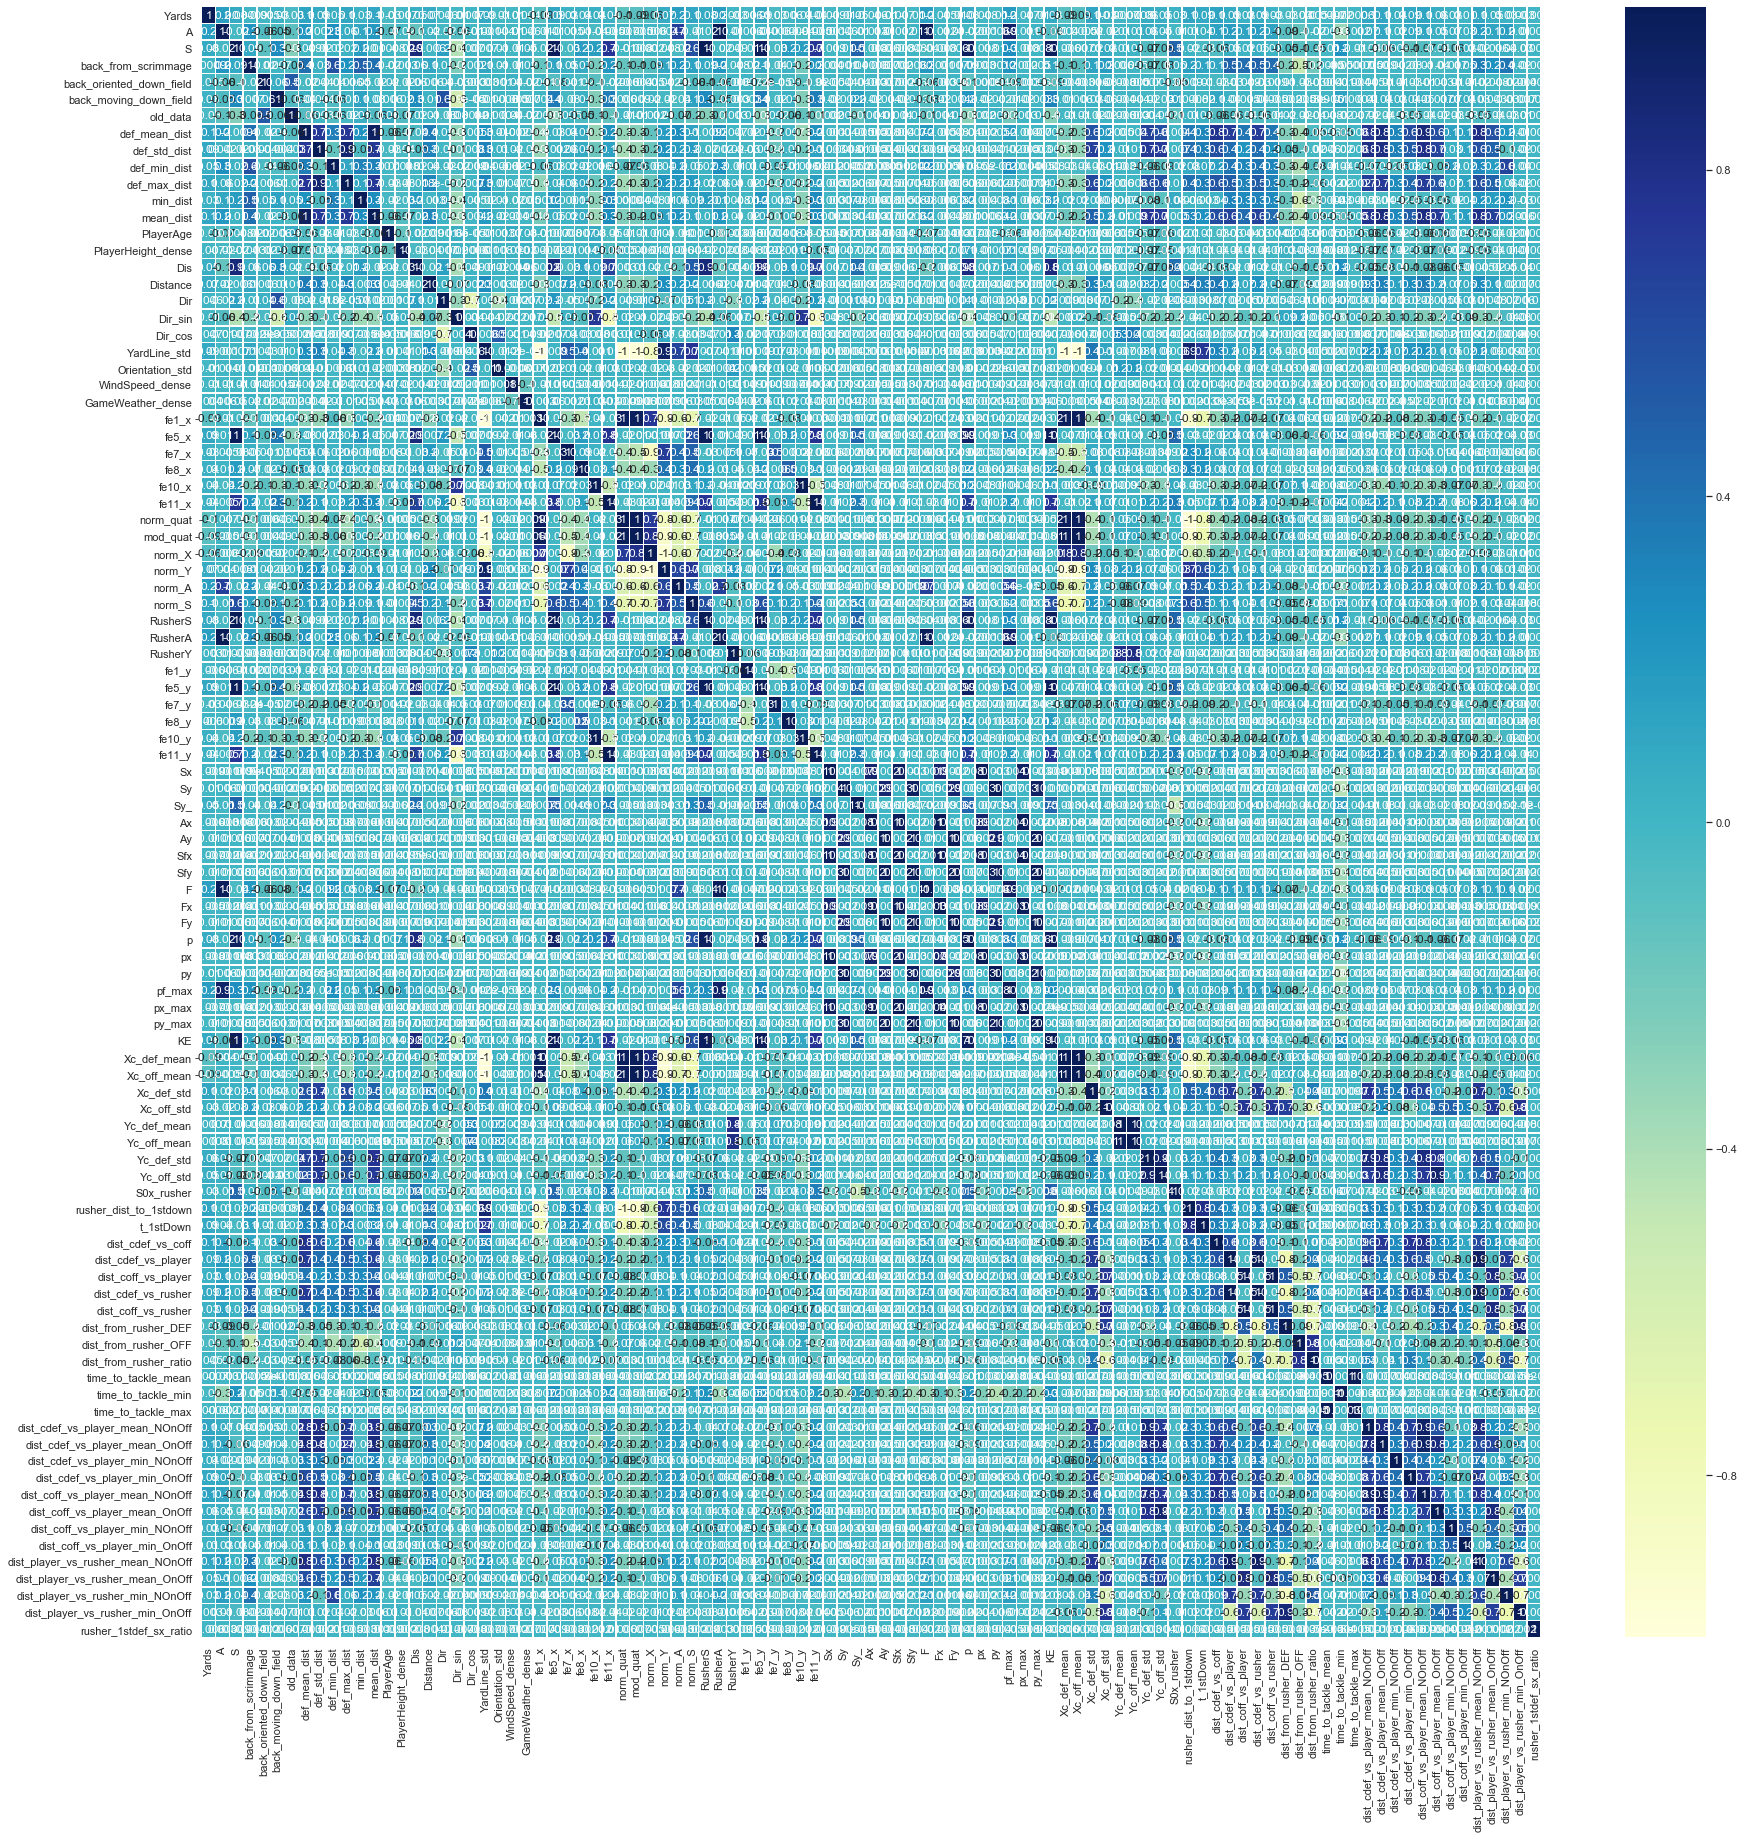

In [106]:
sns.set(rc={'figure.figsize':(30, 30)})
corr = new_X.corr()
plt.figure() 
ax = sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", fmt='.1g')
plt.savefig('corr_heatmap.png')
plt.show()

In [107]:
# Drop highly correlated features (37->28)
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.99:
            if columns[j]:
                columns[j] = False

best_features_revised = new_X.columns[columns].values
drop_columns = new_X.columns[columns == False].values
print(best_features_revised)
print(drop_columns)

['Yards' 'A' 'S' 'back_from_scrimmage' 'back_oriented_down_field'
 'back_moving_down_field' 'old_data' 'def_mean_dist' 'def_std_dist'
 'def_min_dist' 'def_max_dist' 'min_dist' 'mean_dist' 'PlayerAge'
 'PlayerHeight_dense' 'Dis' 'Distance' 'Dir' 'Dir_sin' 'Dir_cos'
 'YardLine_std' 'Orientation_std' 'WindSpeed_dense' 'GameWeather_dense'
 'fe1_x' 'fe5_x' 'fe7_x' 'fe8_x' 'fe10_x' 'fe11_x' 'norm_quat' 'mod_quat'
 'norm_X' 'norm_Y' 'norm_A' 'norm_S' 'RusherY' 'fe1_y' 'fe7_y' 'fe8_y'
 'Sx' 'Sy' 'Sy_' 'Ax' 'Ay' 'F' 'p' 'pf_max' 'KE' 'Xc_def_std' 'Xc_off_std'
 'Yc_def_mean' 'Yc_off_mean' 'Yc_def_std' 'Yc_off_std' 'S0x_rusher'
 'rusher_dist_to_1stdown' 't_1stDown' 'dist_cdef_vs_coff'
 'dist_cdef_vs_player' 'dist_coff_vs_player' 'dist_from_rusher_DEF'
 'dist_from_rusher_OFF' 'dist_from_rusher_ratio' 'time_to_tackle_mean'
 'time_to_tackle_min' 'dist_cdef_vs_player_mean_NOnOff'
 'dist_cdef_vs_player_mean_OnOff' 'dist_cdef_vs_player_min_NOnOff'
 'dist_cdef_vs_player_min_OnOff' 'dist_coff_vs_player_m

In [128]:
new_X = X.loc[:,best_features_revised]
new_X.head()

,Yards,A,S,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,old_data,def_mean_dist,def_std_dist,def_min_dist,def_max_dist,min_dist,mean_dist,PlayerAge,PlayerHeight_dense,Dis,Distance,Dir,Dir_sin,Dir_cos,YardLine_std,Orientation_std,WindSpeed_dense,GameWeather_dense,fe1_x,fe5_x,fe7_x,fe8_x,fe10_x,fe11_x,norm_quat,mod_quat,norm_X,norm_Y,norm_A,norm_S,RusherY,fe1_y,fe7_y,fe8_y,Sx,Sy,Sy_,Ax,Ay,F,p,pf_max,KE,Xc_def_std,Xc_off_std,Yc_def_mean,Yc_off_mean,Yc_def_std,Yc_off_std,S0x_rusher,rusher_dist_to_1stdown,t_1stDown,dist_cdef_vs_coff,dist_cdef_vs_player,dist_coff_vs_player,dist_from_rusher_DEF,dist_from_rusher_OFF,dist_from_rusher_ratio,time_to_tackle_mean,time_to_tackle_min,dist_cdef_vs_player_mean_NOnOff,dist_cdef_vs_player_mean_OnOff,dist_cdef_vs_player_min_NOnOff,dist_cdef_vs_player_min_OnOff,dist_coff_vs_player_mean_NOnOff,dist_coff_vs_player_mean_OnOff,dist_coff_vs_player_min_NOnOff,dist_coff_vs_player_min_OnOff,dist_player_vs_rusher_mean_NOnOff,dist_player_vs_rusher_mean_OnOff,dist_player_vs_rusher_min_NOnOff,dist_player_vs_rusher_min_OnOff,rusher_1stdef_sx_ratio
0,8,3.35,3.63,3.75,1,0,True,9.752491,5.327299,4.593310,22.415872,1.449724,8.046559,25.596251,70,0.38,2,114.26,0.911690,-0.410878,55.0,0.314508,8.0,1.0,27.739531,15.7229,0.0,0.130860,3.309436,1.491487,2658.0428,51.556210,0.800098,0.592169,0.064978,0.070409,30.53,72.591195,0.000000,0.050006,1.440730,3.331846,3.331846,1.329599,3.074844,284.839770,308.647273,1427.806722,512.242125,5.294079,1.772665,28.890909,28.535455,7.014714,5.855606,1.032089,-4.25,-3.125090,4.137117,7.120317,3.443689,0.898305,0.983051,1.094340,3.344904,1.440090,7.308391,6.541702,1.244395,2.768585,8.064384,4.978694,1.829416,1.364298,9.752491,5.609122,4.593310,0.0,-7.261317
1,3,2.41,3.06,4.07,0,0,True,10.297028,5.833217,4.287773,23.025872,0.792023,8.614623,25.596252,70,0.34,10,47.80,0.740805,0.671721,47.0,5.747369,8.0,1.0,40.699869,11.0024,0.0,0.075185,2.266862,2.055465,3146.9822,56.097970,0.872224,0.484153,0.042961,0.054547,27.16,65.675561,0.000000,0.046593,-2.386839,-1.914837,1.914837,-1.879831,-1.508090,204.914581,260.181999,1068.879080,364.002942,5.406292,2.001380,24.892727,24.762727,7.190716,6.932502,2.641076,4.07,2.992733,4.696345,7.961481,3.791370,0.864407,1.152542,1.333333,5.375678,2.039815,7.351094,7.734453,2.300846,4.014345,8.317330,5.893499,1.609979,1.068196,10.297028,6.149070,4.287773,0.0,12.455140
2,5,2.42,5.77,3.66,1,0,True,9.903689,5.073290,4.221670,20.726285,1.646390,8.482583,25.596253,70,0.60,10,138.04,0.668612,-0.743612,25.0,0.683820,8.0,1.0,68.732841,36.1969,0.0,0.083948,3.857889,4.290640,5493.7370,74.119748,0.962497,0.257826,0.032650,0.077847,19.11,44.750458,0.000000,0.128937,5.666081,-1.090151,1.090151,2.376415,-0.457221,205.764849,490.604618,1324.126847,1294.236570,4.720893,2.115286,22.602727,21.450909,6.577620,6.044208,5.408583,-26.34,-19.368206,3.723536,7.866945,4.217487,0.898305,0.915254,1.018868,4.721756,0.526439,6.501208,6.401627,0.676145,1.669572,7.094503,5.099697,1.137575,1.453946,9.903689,6.290334,4.221670,0.0,2.540479
3,2,3.20,4.45,3.53,0,0,True,6.309354,1.834174,4.528002,9.791231,0.918096,5.549379,26.852933,71,0.46,2,84.56,0.995496,0.094803,-8.0,6.174626,8.0,1.0,101.345209,22.7465,0.0,0.043909,4.429957,0.421875,11587.1530,107.643639,0.970517,0.235592,0.029728,0.041340,25.36,20.048658,0.911727,0.221960,-4.296982,1.156912,1.156912,-3.089965,0.831936,278.721988,387.597765,1490.731324,788.583156,0.962418,1.898686,25.733636,25.800000,4.505029,3.154869,4.615931,-100.47,-12.817239,1.593201,4.855307,3.278749,1.000000,1.203390,1.203390,3.876753,1.235714,3.757735,3.324738,0.960504,0.650458,4.162894,3.099234,1.454885,1.017417,6.309354,4.284914,4.528002,0.0,-4.692999
4,7,2.53,3.90,5.01,0,0,True,11.056456,5.900009,4.288088,21.214806,0.502892,9.168819,22.091819,71,0.44,10,157.92,0.375901,-0.926660,65.0,0.598124,8.0,1.0,12.802566,17.4364,0.0,0.304626,1.466013,3.613974,1656.5054,40.700189,0.736852,0.666336,0.062162,0.095823,27.12,12.802566,0.000000,0.304626,2.602038

## Feature Selection

In [142]:
# Importância do Atributo com o Extra Trees Classifier
X_ = new_X.drop(['Yards'], axis=1)
y_ = new_X['Yards']

X_.replace(-np.inf,0,inplace=True)
X_.replace(np.inf,0,inplace=True)
X_.fillna(0,inplace=True)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X_ = StandardScaler().fit_transform(X_)

# Criação do Modelo - Feature Selection
modeloRF = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=15, 
                                  min_samples_split=8, n_estimators=50, n_jobs=-1, random_state=42)
modeloRF.fit(X_, y_)

# Convertendo o resultado em um dataframe
feature_importance_df = pd.DataFrame(new_X.drop(['Yards'], axis=1).columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloRF.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = feature_importance_df.sort_values('importance',ascending=False)
print(result)

                              Feature  importance
0                                   A    0.062183
46                             pf_max    0.054415
44                                  F    0.041887
27                             fe10_x    0.029647
57                  dist_cdef_vs_coff    0.025213
17                            Dir_sin    0.024337
5                            old_data    0.021977
69    dist_coff_vs_player_mean_NOnOff    0.021927
48                         Xc_def_std    0.021787
2                 back_from_scrimmage    0.021202
47                                 KE    0.017979
33                             norm_A    0.017808
24                              fe5_x    0.017028
49                         Xc_off_std    0.016758
28                             fe11_x    0.016352
65    dist_cdef_vs_player_mean_NOnOff    0.016005
23                              fe1_x    0.014790
55             rusher_dist_to_1stdown    0.014642
10                           min_dist    0.014444


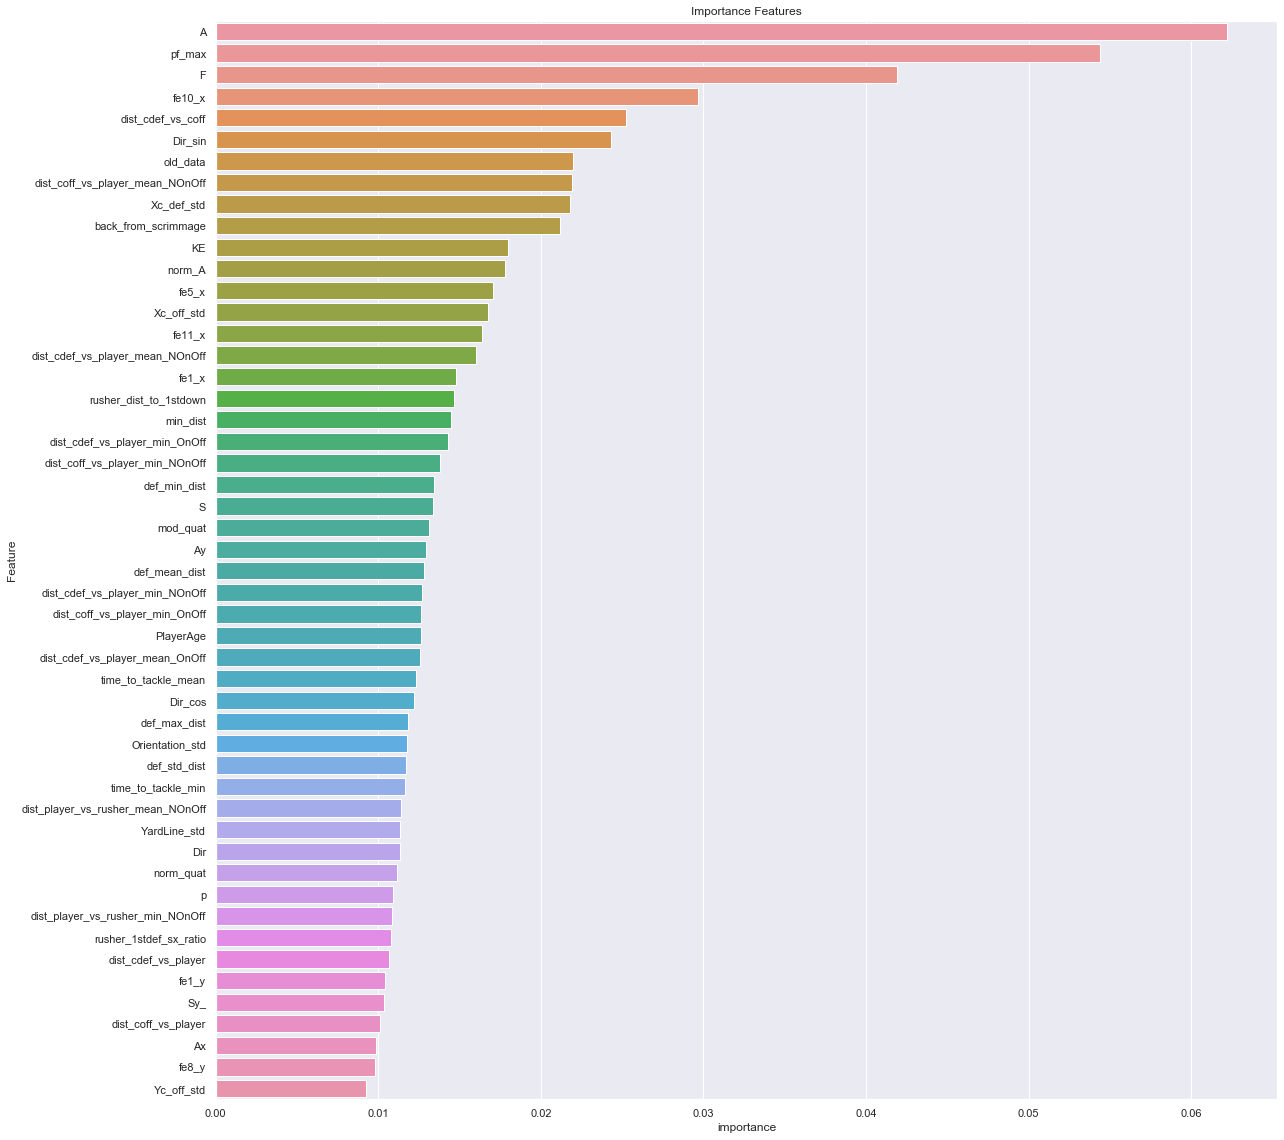

In [144]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,16))
sns.barplot(x="importance",
           y="Feature",
           data=best_features.sort_values(by="importance",
                                          ascending=False))
plt.title('Importance Features')
plt.tight_layout()

In [146]:
best_features['Feature']

0                                     A
1                                     S
2                   back_from_scrimmage
5                              old_data
6                         def_mean_dist
7                          def_std_dist
8                          def_min_dist
9                          def_max_dist
10                             min_dist
12                            PlayerAge
16                                  Dir
17                              Dir_sin
18                              Dir_cos
19                         YardLine_std
20                      Orientation_std
23                                fe1_x
24                                fe5_x
27                               fe10_x
28                               fe11_x
29                            norm_quat
30                             mod_quat
33                               norm_A
36                                fe1_y
38                                fe8_y
41                                  Sy_


## 4. Criar e avaliar alguns algoritmos de Machine Learning

### 4.1. Split Treino e Validação

In [147]:
# Criar um dataset somente com as colunas mais importantes conforme visto anteriormente
new_X = X.loc[:,best_features['Feature']]
new_X.replace(-np.inf,0,inplace=True)
new_X.replace(np.inf,0,inplace=True)
new_X.fillna(0,inplace=True)


target = X.Yards

y = np.zeros((target.shape[0], 199))
for idx, target in enumerate(list(target)):
    y[idx][99 + target] = 1
    
# Normalizando as variaveis do dataset de treino
scaler = StandardScaler()
new_X = scaler.fit_transform(new_X)
new_X.shape, y.shape

((23171, 50), (23171, 199))

### 4.2. Teste 3 modelos (LightGBM, RF e NN)

In [160]:
# Calculate CRPS score
def crps_score(y_prediction, y_valid, shape=X.shape[0]):
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_prediction, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * shape)
    crps = np.round(val_s, 6)
    
    return crps

In [161]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        #print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [162]:
#from keras.regularizers import l2,l1, l1_l2

def get_nn(x_tr,y_tr,x_val,y_val,shape):
    K.clear_session()
    inp = Input(shape = (x_tr.shape[1],))
    
    x = Dense(1024, input_dim=X.shape[1], activation='relu')(inp)# bias_regularizer=l1_l2(l1=0.05,l2=0.05))(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp,out)
    
    model.compile(optimizer = optimizers.adam(lr = 0.05, decay = 0.05),
                  loss='categorical_crossentropy', 
                  metrics=[])
     
    es = EarlyStopping(monitor='CRPS_score_val', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=0, 
                       patience=15)

    mc = ModelCheckpoint('best_model.h5',monitor='CRPS_score_val',mode='min',save_best_only=True, 
                         verbose=0, save_weights_only=True)
    
    bsz = 1024
    model.fit(x_tr, y_tr,
              callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], 
              epochs=200, 
              batch_size=bsz,
              verbose=0)
    
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    crps = crps_score(y_pred, y_valid, shape=shape)

    return model,crps

In [163]:
metric = "multi_logloss"
param = {'num_leaves': 50,
         'min_data_in_leaf': 30,
         'objective':'multiclass',
         'num_class': 199,
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": metric,
         "lambda_l1": 0.1,
         "verbosity": -1,
         "seed":1234}

In [164]:
def get_lgbm(x_tr, y_tr, x_val, y_val, shape):
    y_valid = y_val
    y_tr = np.argmax(y_tr, axis=1)
    y_val = np.argmax(y_val, axis=1)
    trn_data = lgb.Dataset(x_tr, label=y_tr)
    val_data = lgb.Dataset(x_val, label=y_val)
    model = lgb.train(param, trn_data, 10000, valid_sets = [val_data], verbose_eval = 100, early_stopping_rounds = 200)
    
    y_pred = model.predict(x_val, num_iteration=model.best_iteration)
    crps = crps_score(y_pred, y_valid, shape=shape)
    
    return model, crps

In [165]:
def get_rf(x_tr, y_tr, x_val, y_val, shape):
    model = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=15, 
                                  min_samples_split=8, n_estimators=50, n_jobs=-1, random_state=42)
    model.fit(x_tr, y_tr)
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    crps = crps_score(y_pred, y_valid, shape=shape)
    
    return model, crps

In [166]:
%%time

loop = 2
fold = 5

oof_nn = np.zeros([loop, y.shape[0], y.shape[1]])
oof_lgbm = np.zeros([loop, y.shape[0], y.shape[1]])
oof_rf = np.zeros([loop, y.shape[0], y.shape[1]])

models_nn = []
crps_csv_nn = []

models_lgbm = []
crps_csv_lgbm = []

models_rf = []
crps_csv_rf = []

for k in range(loop):
    kfold = KFold(fold, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(y)):
        print("-----------")
        print(f'Loop {k+1}/{loop}' + f' Fold {k_fold+1}/{fold}')
        print("-----------")
        
        tr_x, tr_y = new_X[tr_inds], y[tr_inds]
        val_x, val_y = new_X[val_inds], y[val_inds]
        
        # Train NN
        nn, crps_nn = get_nn(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
        models_nn.append(nn)
        print("the %d fold crps (NN) is %f"%((k_fold+1), crps_nn))
        crps_csv_nn.append(crps_nn)
        
        # Train LGBM
        lgbm, crps_lgbm = get_lgbm(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
        models_lgbm.append(lgbm)
        print("the %d fold crps (LGBM) is %f"%((k_fold+1), crps_lgbm))
        crps_csv_lgbm.append(crps_lgbm)
        
#         # Train RF
#         rf, crps_rf = get_rf(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
#         models_rf.append(rf)
#         print("the %d fold crps (RF) is %f"%((k_fold+1), crps_rf))
#         crps_csv_rf.append(crps_rf)
        
        #Predict OOF
        oof_nn[k, val_inds, :] = nn.predict(val_x)
        oof_lgbm[k, val_inds, :] = lgbm.predict(val_x, num_iteration=lgbm.best_iteration)
#        oof_rf[k, val_inds, :] = rf.predict(val_x)


-----------
Loop 1/2 Fold 1/5
-----------


KeyboardInterrupt: 

In [99]:
crps_oof_nn = []
#crps_oof_lgbm = []
#crps_oof_rf = []

for k in range(loop):
    crps_oof_nn.append(crps_score(oof_nn[k,...], y))
    #crps_oof_lgbm.append(crps_score(oof_lgbm[k,...], y))
    #crps_oof_rf.append(crps_score(oof_rf[k,...], y))

In [100]:
print("mean crps (NN) is %f"%np.mean(crps_csv_nn))
#print("mean crps (LGBM) is %f"%np.mean(crps_csv_lgbm))
#print("mean crps (RF) is %f"%np.mean(crps_csv_rf))

mean crps (NN) is 0.012639


In [101]:
print("mean OOF crps (NN) is %f"%np.mean(crps_oof_nn))
#print("mean OOF crps (LGBM) is %f"%np.mean(crps_oof_lgbm))
# print("mean OOF crps (RF) is %f"%np.mean(crps_oof_rf))

mean OOF crps (NN) is 0.012639


## 6. Blending Weight Optimisation

In [ ]:
weight_nn, weight_lgbm = weight_opt(oof_nn, oof_lgbm, y)
# weight_nn, weight_rf = weight_opt(oof_nn, oof_rf, y)

## 5. Realizar a submissão para o Kaggle

In [ ]:
def predict(x_te, models_nn):
    
    model_num_nn = len(models_nn)

    for k,m in enumerate(models_nn):
        if k==0:
            y_pred_nn = m.predict(x_te, batch_size=1024)
        else:
            y_pred_nn += m.predict(x_te, batch_size=1024)
            
    y_pred_nn = y_pred_nn / model_num_nn
    
    return y_pred_nn

In [ ]:
%%time

if  TRAIN_OFFLINE==False:
    
    from kaggle.competitions import nflrush
    env = nflrush.make_env()
    iter_test = env.iter_test()
    df_prev = pd.DataFrame()
    df_test = pd.DataFrame()

    for (test_df, sample_prediction_df) in tqdm_notebook(iter_test):
        
        basetable_01 = create_features_01(test_df, deploy=True)
        basetable_02 = create_features_02(basetable_01)
        basetable_03 = create_features_03(test_df, False)
        
        #??? PRECISA ARRUMAR AQUI
        X = pd.merge(basetable_02, basetable_03, on=['GameId','PlayId'], how='inner')

        # Considerar somente as colunas do Feature Selection
        X = X.loc[:,best_features_revised]
        X.fillna(0,inplace=True)
    
        scaled_basetable = scaler.transform(X)
        
        y_pred = predict(scaled_basetable, models_nn)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

        preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
        
        df_test = df_test.append(X)
        df_prev = df_prev.append(preds_df)
    
        env.predict(preds_df)

    env.write_submission_file()

In [ ]:
df_test.head()

In [ ]:
df_prev.head()